In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import sys
sys.path.append('../src')

import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import pearsonr

In [65]:
from spaceoracle.models.estimators import ViTEstimatorV2

In [66]:
from spaceoracle.callbacks.simulation_callback import SimulationBetaCallbackV2
from spaceoracle.callbacks.fixtures.simulator import SimulatedDataV2

In [67]:
# Simulated data pt1

sim_data = SimulatedDataV2(ntfs=20, clusters=6)
estimator = ViTEstimatorV2(sim_data.adata, target_gene='target_gene', 
                        regulators=sim_data.tf_labels, n_clusters=sim_data.clusters)

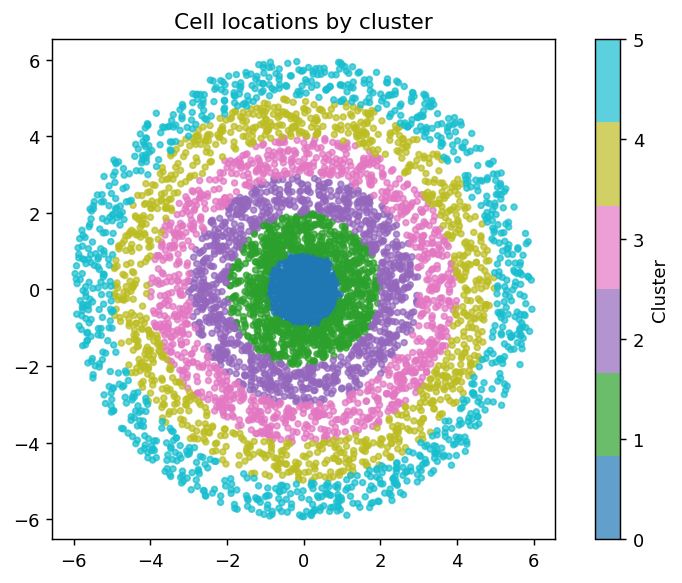

In [68]:
cmap = mcolors.ListedColormap(plt.cm.get_cmap('tab10', sim_data.clusters).colors)
scatter = plt.scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.labels, cmap=cmap, s=10, alpha=0.7)

plt.colorbar(scatter, label="Cluster")

plt.title('Cell locations by cluster')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


[cuda] MSE: 0.0246 | Baseline: 7.4543: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]

Best model at 17/20


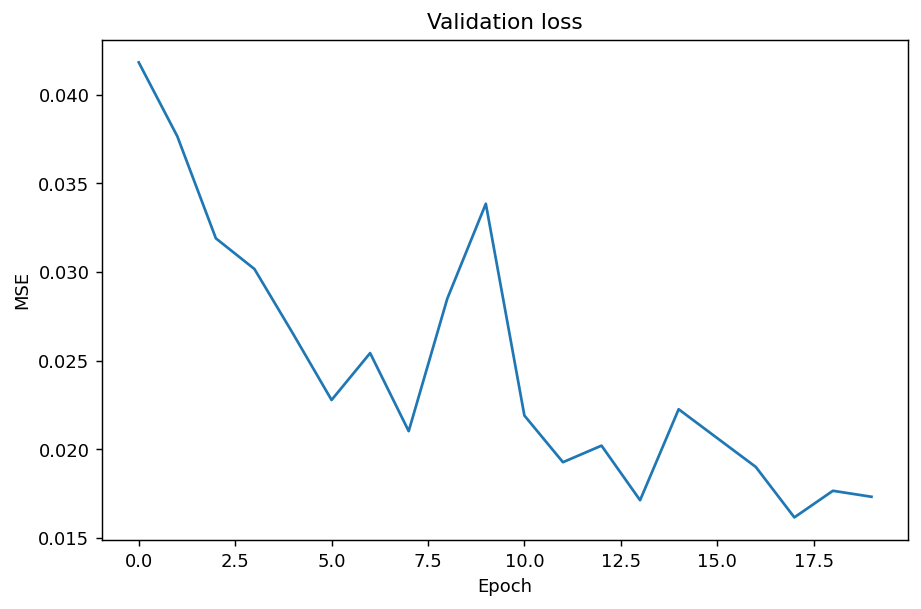

In [80]:
estimator.fit(
    annot='sim_cluster', 
    max_epochs=20, 
    learning_rate=0.01, 
    spatial_dim=64,
    batch_size=32,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, n_heads=2, n_blocks=2, hidden_d=16
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 130
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation loss')
plt.show()

In [81]:
check_betas = SimulationBetaCallbackV2()

with torch.no_grad():
    beta_pred = estimator.get_betas(
        np.array(sim_data.adata.obsm['spatial']),
        np.array(sim_data.adata.obs['sim_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(sim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

check_betas(beta_pred, sim_data.betas)

{'beta0': 0.00236189142432174,
 'beta1': 0.041331214845140754,
 'beta2': 0.5542051588558579,
 'beta3': 0.5403100203982708,
 'beta4': -0.10873574389149866,
 'beta5': 0.170377962031673,
 'beta6': 0.20586987889730657,
 'beta7': 0.3358963542155113,
 'beta8': 0.6177503067772685,
 'beta9': -0.1186384915001265,
 'beta10': 0.7104859977924326,
 'beta11': 0.2336994188524036,
 'beta12': 0.13558043709537124,
 'beta13': 0.461710943243597,
 'beta14': 0.49875176762825396,
 'beta15': -0.1328802795487838,
 'beta16': 0.5951589147910618,
 'beta17': -0.10711631094855245,
 'beta18': -0.09343026509579931,
 'beta19': 0.23690833332203812,
 'beta20': 0.7678646314472573}

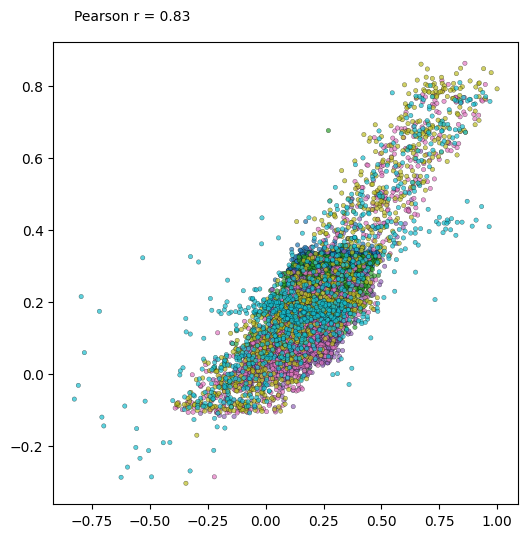

In [82]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = sim_data.y
sns.scatterplot(
    x=y.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=sim_data.adata.obs['sim_cluster'].values[:], cmap=cmap, edgecolor='black', linewidth=0.25, alpha=0.7)

corr, _ = pearsonr(y.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.min(), 
    y=y_pred.max()+0.15, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()

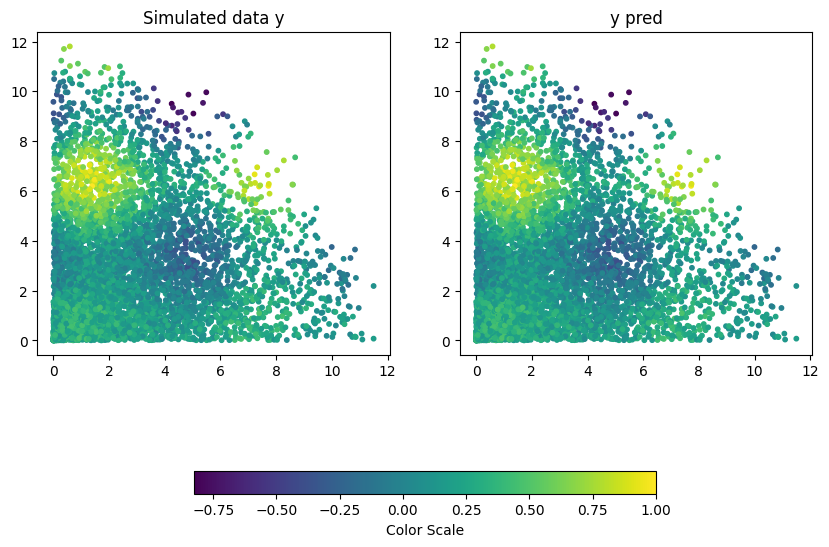

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("y pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

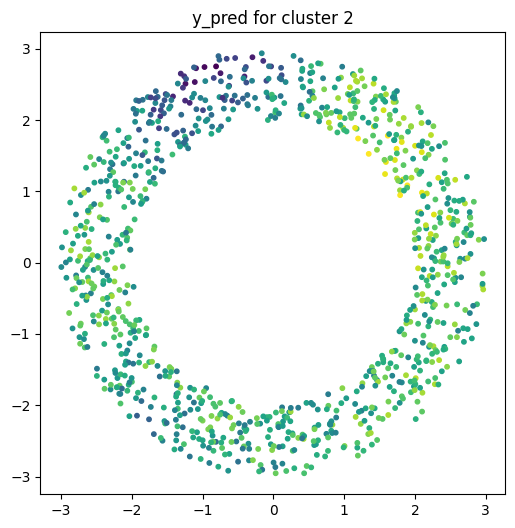

In [73]:
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()
plt.scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], c=sim_data.y[indices], s=10)
_ = plt.title(f'y_pred for cluster {cool_cluster}')

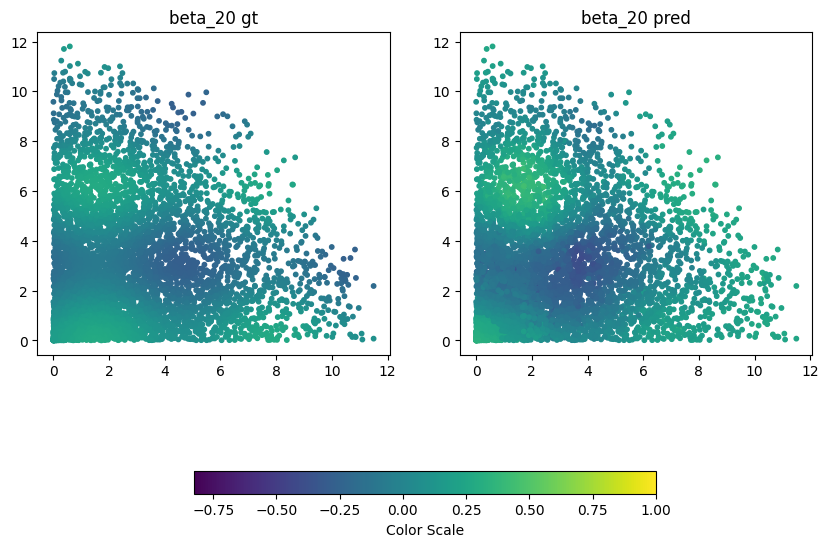

In [84]:
hot_beta = 20

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=beta_pred[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

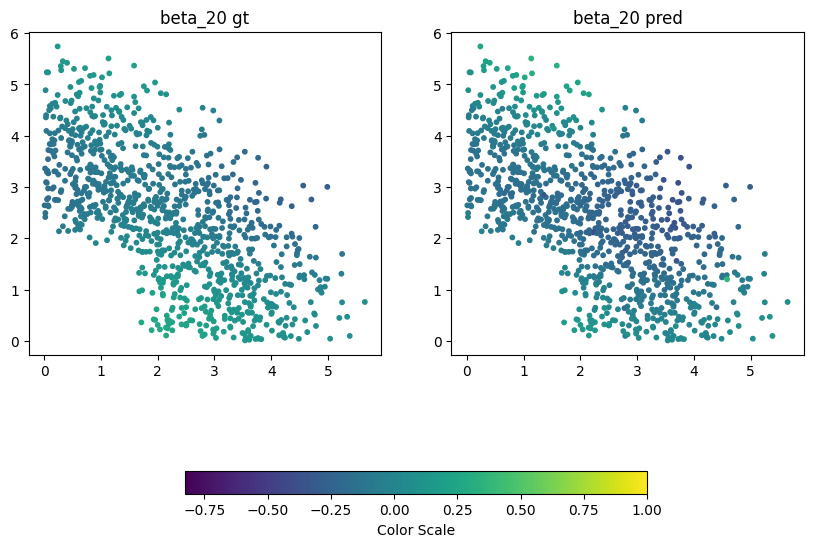

In [85]:
hot_beta = 20
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=sim_data.betas[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=beta_pred[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

In [76]:
# Simulated Data pt2

sim_data = SimulatedDataV2(ntfs=20, clusters=6, position='wave')
estimator = ViTEstimatorV2(sim_data.adata, target_gene='target_gene', 
                        regulators=sim_data.tf_labels, n_clusters=sim_data.clusters)

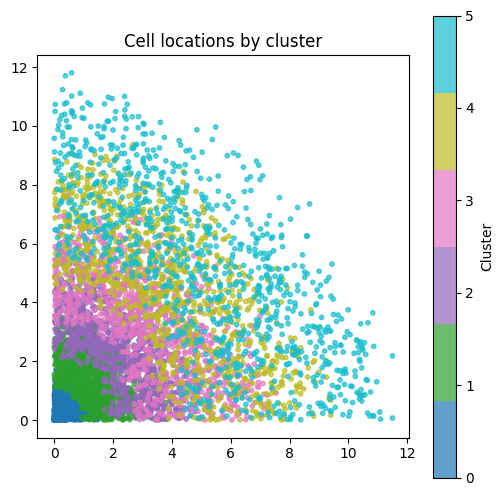

In [77]:
plt.figure(figsize=(6,6))

cmap = mcolors.ListedColormap(plt.cm.get_cmap('tab10', sim_data.clusters).colors)
scatter = plt.scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.labels, cmap=cmap, s=10, alpha=0.7)

plt.colorbar(scatter, label="Cluster")

plt.title('Cell locations by cluster')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


[cuda] MSE: 0.0167 | Baseline: 7.4543: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it]

Best model at 97/100


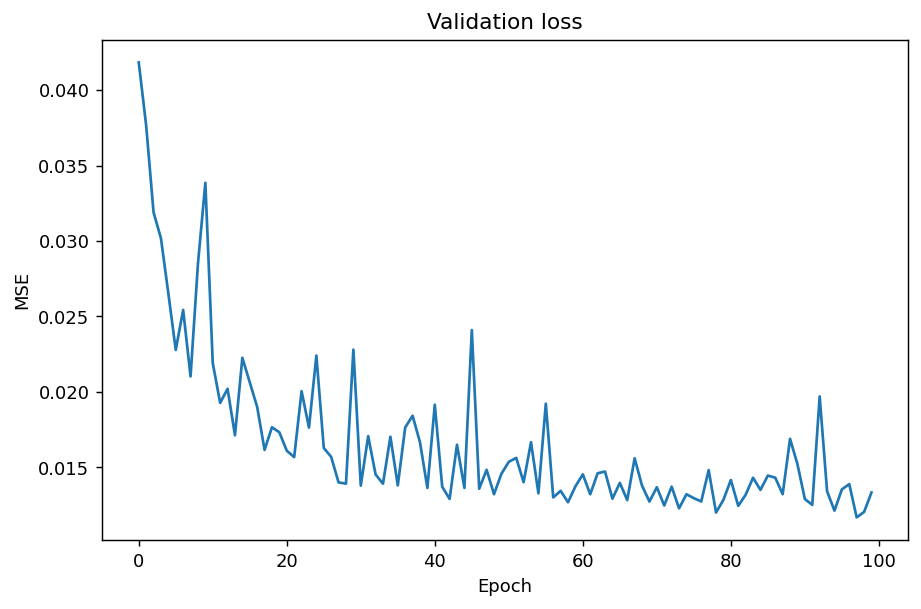

In [78]:
estimator.fit(
    annot='sim_cluster', 
    max_epochs=100, 
    learning_rate=0.01, 
    spatial_dim=64,
    batch_size=32,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, n_heads=2, n_blocks=2, hidden_d=16
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 130
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation loss')
plt.show()

In [79]:
check_betas = SimulationBetaCallbackV2()

with torch.no_grad():
    beta_pred = estimator.get_betas(
        np.array(sim_data.adata.obsm['spatial']),
        np.array(sim_data.adata.obs['sim_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(sim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

check_betas(beta_pred, sim_data.betas)

KeyboardInterrupt: 

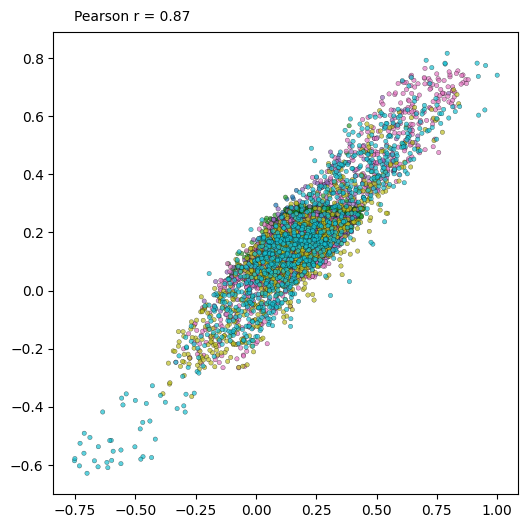

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = sim_data.y
sns.scatterplot(
    x=y.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=sim_data.adata.obs['sim_cluster'].values[:], cmap=cmap, edgecolor='black', linewidth=0.25, alpha=0.7)

corr, _ = pearsonr(y.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.min(), 
    y=y_pred.max()+0.15, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()